# **First Stage Example: AI-Powered Audio Enhancer with Conv-TasNet**

**Interview Application Task (a very early stage exercise task - much more work needed!)**

This Python application enhances audio recordings by simulating room acoustics with a Room Impulse Response (RIR) and denoising speech using **Conv-TasNet**, a deep learning source separation model from the [Asteroid library](https://asteroid.readthedocs.io/en/v0.3.3/why_use_asteroid.html).

- Conv-TasNet API: [Asteroid Conv-TasNet](https://asteroid.readthedocs.io/en/v0.3.3/apidoc/asteroid.models.conv_tasnet.html)  
- IR Data Source: [OpenAIR Database](https://www.openair.hosted.york.ac.uk/?page_id=36)  

**First Stage Wider Topic Reading:**  
van Waterschoot, T. (2025). *Deep, data-driven modeling of room acoustics: Literature review and research perspectives*. arXiv. https://doi.org/10.48550/arXiv.2504.16289  

**Prior Knowledge / Tools:**  
Isotope Tools: RX, Ozone, Neutron  

**Key Features:**  
- AI-powered audio enhancement using Conv-TasNet  
- RIR simulation for room acoustics  
- Overlap-add processing for smooth chunked enhancement  
- Live plotting of audio chunks  
- Supports mono or stereo audio input  
- Normalised output for high-quality playback  

**Usage - before running:**  
1. Upload `input_audio.wav`  
2. Upload RIR files: `rir_room1.wav`, `rir_room2.wav`  



Features:

- AI-powered audio enhancement using Conv-TasNet.
- RIR simulation for room acoustics.
- Overlap-add processing for smooth chunked enhancement.
- Live plotting of audio chunks
- Supports mono or stereo audio input.
- Normalised output for high-quality playback.

Install dependencies:

In [ ]:
!pip install --upgrade speechbrain torchaudio soundfile matplotlib asteroid ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.4/156.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

Imports:

In [ ]:
import torch
import torchaudio
import numpy as np
import soundfile as sf
from asteroid.models import ConvTasNet
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
from IPython.display import clear_output
from IPython.display import Audio
import time

%matplotlib inline

Configuration (CHUNK_SIZE, RATE, RIR toggles):

*Define key processing parameters such as sample rate, chunk size, overlap, and whether to apply a Room Impulse Response (RIR). These control how audio is segmented and enhanced.*

In [ ]:
CHUNK_SIZE = 2048
HOP_SIZE = CHUNK_SIZE // 2
RATE = 16000
window = np.sqrt(np.hanning(CHUNK_SIZE))  # square-root Hann for perfect overlap-add

INPUT_FILE = "input_audio.wav"

# Room Impulse Response (RIR) configuration
APPLY_RIR = True  # toggle RIR on/off
RIR_FILES = ["rir_room1.wav", "rir_room2.wav"]
RIR_INDEX = 1     # select which RIR to apply

Load input audio:

*Read the uploaded input file, convert it to mono if needed, resample it to the model’s working rate, and normalise it for consistent processing quality.*

In [ ]:
audio, sr = sf.read(INPUT_FILE)
if sr != RATE:
    audio = torchaudio.functional.resample(torch.tensor(audio), orig_freq=sr, new_freq=RATE).numpy()
audio = audio.astype(np.float32)
if audio.ndim == 2:  # stereo → mono
    audio = audio.mean(axis=1)
audio /= np.max(np.abs(audio))  # normalise

Load RIR:

*If enabled, load a Room Impulse Response (RIR) file to simulate the acoustics of a physical room. The RIR is resampled and converted to mono for convolution.*

In [ ]:
rir = None
if APPLY_RIR:
    rir, rir_sr = sf.read(RIR_FILES[RIR_INDEX])
    if rir_sr != RATE:
        rir = torchaudio.functional.resample(torch.tensor(rir), orig_freq=rir_sr, new_freq=RATE).numpy()
    if rir.ndim == 2:
        rir = rir.mean(axis=1)
    rir = rir.astype(np.float32)
    print(f"Applied RIR from {RIR_FILES[RIR_INDEX]}")
else:
    print("RIR disabled")

Applied RIR from rir_room2.wav


Load enhancement model (Conv-TasNet):

*Download and initialise the pretrained Conv-TasNet model from the Asteroid library. This model performs the AI-based speech enhancement and denoising.*

In [ ]:
model = ConvTasNet.from_pretrained("JorisCos/ConvTasNet_Libri2Mix_sepclean_16k")
model.eval()
print("Loaded Conv-TasNet model.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded Conv-TasNet model.


Set up plotting (live visualisation):

*Create Matplotlib plots for visual feedback. The notebook will display waveforms of original and enhanced chunks during processing for easy comparison.*

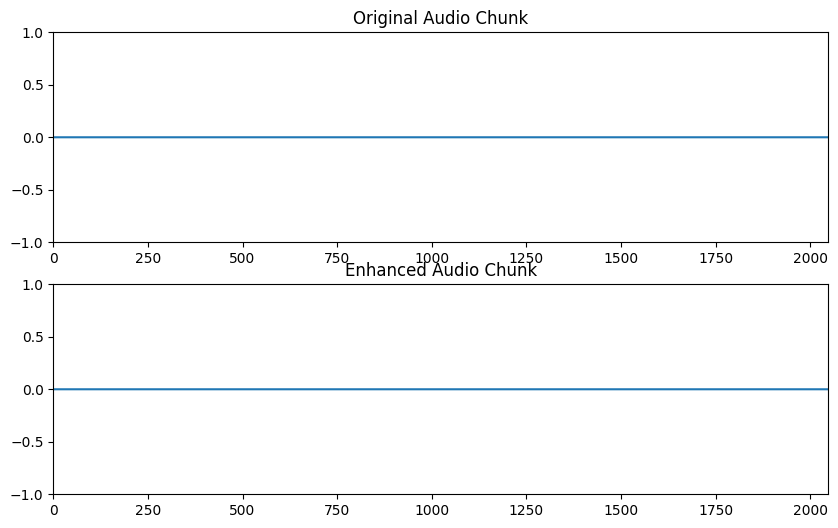

In [ ]:
plt.ion()
fig, ax = plt.subplots(2, 1, figsize=(10,6))
line_orig, = ax[0].plot(np.zeros(CHUNK_SIZE))
line_enh, = ax[1].plot(np.zeros(CHUNK_SIZE))
ax[0].set_title("Original Audio Chunk")
ax[1].set_title("Enhanced Audio Chunk")
for a in ax:
    a.set_ylim(-1.0, 1.0)
    a.set_xlim(0, CHUNK_SIZE)
plt.show()

Process audio with overlap-add (initialisation):

*Prepare output buffers and calculate how many chunks of audio will be processed. This sets up the overlap-add method used for smooth reconstruction between frames.*


In [ ]:
# amended for plot display in online Colab
processed_audio = np.zeros(len(audio) + HOP_SIZE, dtype=np.float32)
num_chunks = (len(audio) - CHUNK_SIZE) // HOP_SIZE + 1  # may miss last partial chunk - pad last chunk?
start_time = time.time()


Main processing loop:

*Iterate through each overlapping chunk of audio, apply the RIR if enabled, run Conv-TasNet enhancement, apply the window function, and reconstruct the full signal with overlap-add.*

In [ ]:
# Main processing loop:
for i in range(num_chunks):
    start_idx = i * HOP_SIZE
    chunk = audio[start_idx:start_idx+CHUNK_SIZE].copy()

    # Apply RIR if enabled
    if APPLY_RIR and rir is not None:
        chunk = fftconvolve(chunk, rir, mode='same')

    # Enhance
    chunk_tensor = torch.from_numpy(chunk.astype(np.float32)).unsqueeze(0)
    with torch.no_grad():
        enhanced_chunk = model(chunk_tensor).squeeze(0).detach().cpu().numpy()

    # If multi-channel, take first channel
    if enhanced_chunk.ndim > 1:
        enhanced_chunk = enhanced_chunk[0]

    # Window before overlap-add
    enhanced_chunk *= window
    processed_audio[start_idx:start_idx+CHUNK_SIZE] += enhanced_chunk

Progress display and plotting:

*Show progress updates and periodically refresh the waveform plots. This provides real-time visual monitoring of enhancement progress within Colab.*

Processing chunk 104/104 (100.0%)


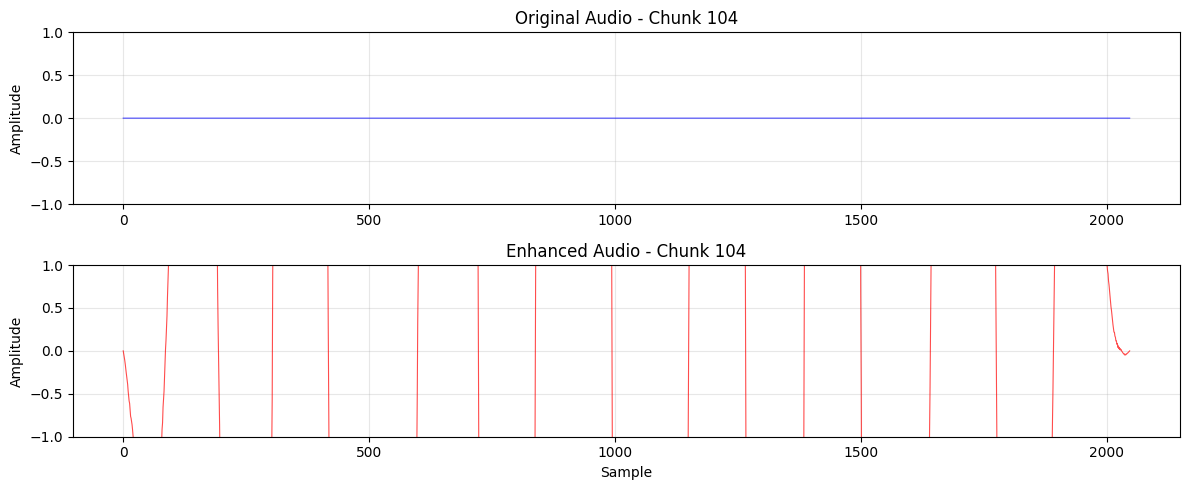

Processed 104 chunks in 10.94 seconds.


In [ ]:
    # Progress display and plotting:
    # Show progress and plot every 20 chunks (Colab-friendly approach)
    if i % 20 == 0 or i == num_chunks - 1:
        clear_output(wait=True)
        print(f"Processing chunk {i+1}/{num_chunks} ({(i+1)/num_chunks*100:.1f}%)")

        # Create plot
        fig, ax = plt.subplots(2, 1, figsize=(12, 5))
        ax[0].plot(chunk[:CHUNK_SIZE], 'b-', alpha=0.7, linewidth=0.8)
        ax[0].set_title(f"Original Audio - Chunk {i+1}")
        ax[0].set_ylim(-1, 1)
        ax[0].set_ylabel("Amplitude")
        ax[0].grid(True, alpha=0.3)

        ax[1].plot(enhanced_chunk[:CHUNK_SIZE], 'r-', alpha=0.7, linewidth=0.8)
        ax[1].set_title(f"Enhanced Audio - Chunk {i+1}")
        ax[1].set_ylim(-1, 1)
        ax[1].set_ylabel("Amplitude")
        ax[1].set_xlabel("Sample")
        ax[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

end_time = time.time()
print(f"Processed {num_chunks} chunks in {end_time - start_time:.2f} seconds.")

Normalise and save output:

*After processing all chunks, normalise the full audio to prevent clipping and save the enhanced result as a WAV file for playback or export.*

In [ ]:
processed_audio /= max(np.abs(processed_audio).max(), 1e-9)
sf.write("enhanced_audio.wav", processed_audio, RATE)
print("Saved enhanced_audio.wav")
print("Audio length:", len(audio))
print("Chunk size:", CHUNK_SIZE)
print("Number of chunks:", num_chunks)

Saved enhanced_audio.wav
Audio length: 107862
Chunk size: 2048
Number of chunks: 104


In [ ]:
print("Audio length:", len(audio))
print("Chunk size:", CHUNK_SIZE)
num_chunks = len(audio) // CHUNK_SIZE
print("Number of chunks:", num_chunks)

print("processed_audio before loop:", processed_audio)

Audio length: 107862
Chunk size: 2048
Number of chunks: 52
processed_audio before loop: [ 0.0000000e+00  3.0668176e-07 -7.2388883e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]


Playback original audio:

In [ ]:
from IPython.display import Audio
print("Original audio:")
Audio("input_audio.wav", rate=RATE)

Original audio:


Playback enhanced audio (with new auditory environment applied):

In [ ]:
print("Enhanced audio:")
Audio("enhanced_audio.wav", rate=RATE)

Enhanced audio:


Next steps / improvement ideas:

- Extending the project with padding for partial chunks
- GPU acceleration
- evaluation metrics (e.g. SI-SDR) or multichannel support for advanced use cases.